## Predicting the Rentals Bike Count

### Import libraries

In [1]:
# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from math import sqrt

import calendar
from datetime import datetime

import warnings

# Plotting parameters tuning
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### Load the dataset

In [3]:
day_df = pd.read_csv("day.csv")
df = pd.read_csv("bs_per_hour.csv")

In [4]:
#we will be using hour dataset as it contains more number of records.
print("Number of column and rows in day dataset:",day_df.shape)
print("Number of colns and rows in hour dataset:",df.shape)

Number of column and rows in day dataset: (731, 16)
Number of colns and rows in hour dataset: (17379, 17)


In [5]:
description = ['Will be excluded','Will be excluded','Categorical','Will be excluded','Will be excluded',
               'Numerical','Categorical','Categorical','Categorical','Categorical',
               'Numerical','Will be excluded','Numerical','Numerical','Numerical','Will be excluded','Target Variable[Numerical]']

In [7]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [8]:
new_df = pd.DataFrame({'Attribute': df.columns,'Data Type' : df.dtypes,'Description' : description})
new_df

,Attribute,Data Type,Description
instant,instant,int64,Will be excluded
dteday,dteday,object,Will be excluded
season,season,int64,Categorical
yr,yr,int64,Will be excluded
mnth,mnth,int64,Will be excluded
hr,hr,int64,Numerical
holiday,holiday,int64,Categorical
weekday,weekday,int64,Categorical
workingday,workingday,int64,Categorical
weathersit,weathersit,int64,Categorical


In [9]:
print(new_df.apply(np.roll, shift=1))

             Attribute Data Type                 Description
instant            cnt     int64  Target Variable[Numerical]
dteday         instant     int64            Will be excluded
season          dteday    object            Will be excluded
yr              season     int64                 Categorical
mnth                yr     int64            Will be excluded
hr                mnth     int64            Will be excluded
holiday             hr     int64                   Numerical
weekday        holiday     int64                 Categorical
workingday     weekday     int64                 Categorical
weathersit  workingday     int64                 Categorical
temp        weathersit     int64                 Categorical
atemp             temp   float64                   Numerical
hum              atemp   float64            Will be excluded
windspeed          hum   float64                   Numerical
casual       windspeed   float64                   Numerical
registered      casual  

### Step 3. Data Preprocessing

In [10]:
#Renaming the column names to be more readable
df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

# Setting proper data types
# date time conversion
df['datetime'] = pd.to_datetime(df.datetime)

# categorical variables
df['season'] = df.season.astype('category')
df['is_holiday'] = df.is_holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather_condition'] = df.weather_condition.astype('category')
df['is_workingday'] = df.is_workingday.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')

#### Analysing and removing the unused features

In [11]:
df.dtypes

rec_id                        int64
datetime             datetime64[ns]
season                     category
year                       category
month                      category
hour                       category
is_holiday                 category
weekday                    category
is_workingday              category
weather_condition          category
temp                        float64
atemp                       float64
humidity                    float64
windspeed                   float64
casual                        int64
registered                    int64
total_count                   int64
dtype: object

## check missing values

In [12]:
df.isnull().sum().value_counts

<bound method IndexOpsMixin.value_counts of rec_id               0
datetime             0
season               0
year                 0
month                0
hour                 0
is_holiday           0
weekday              0
is_workingday        0
weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
total_count          0
dtype: int64>

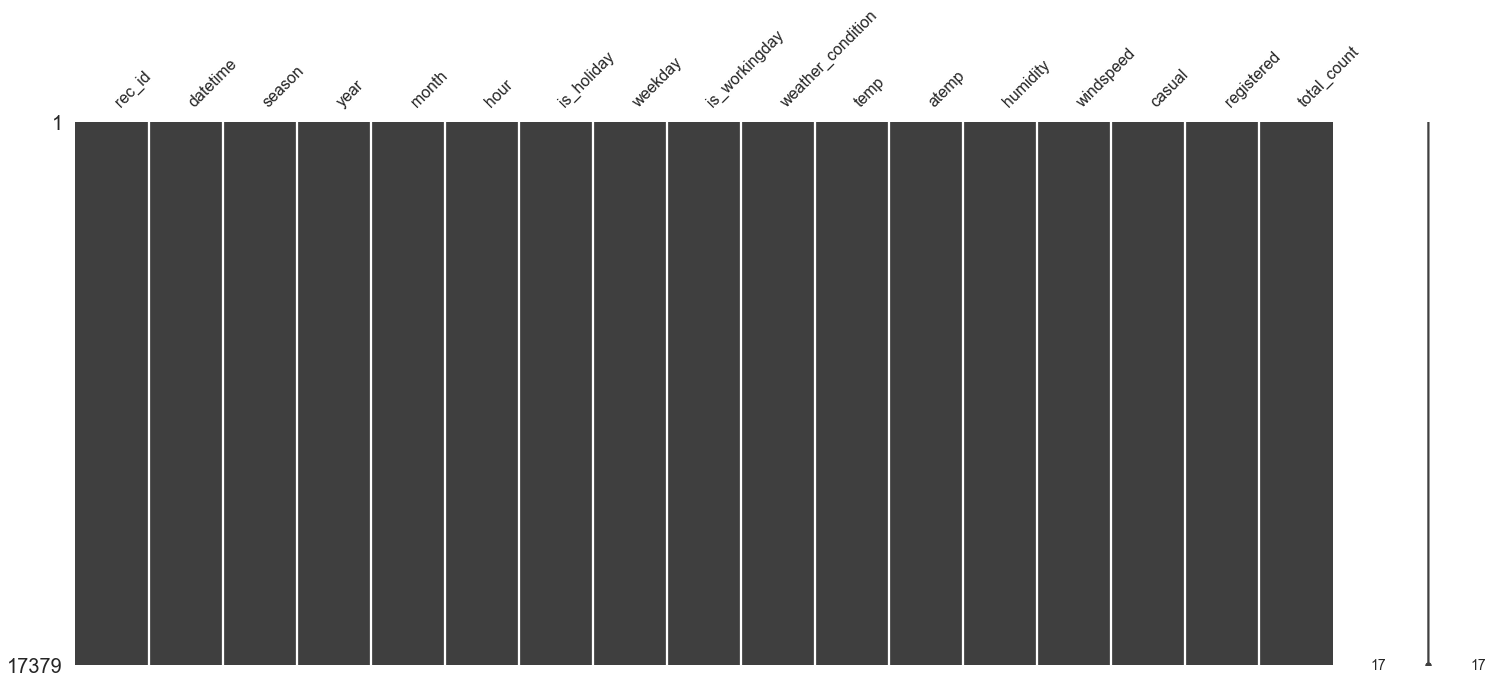

In [13]:
missingno.matrix(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rec_id             17379 non-null  int64         
 1   datetime           17379 non-null  datetime64[ns]
 2   season             17379 non-null  category      
 3   year               17379 non-null  category      
 4   month              17379 non-null  category      
 5   hour               17379 non-null  category      
 6   is_holiday         17379 non-null  category      
 7   weekday            17379 non-null  category      
 8   is_workingday      17379 non-null  category      
 9   weather_condition  17379 non-null  category      
 10  temp               17379 non-null  float64       
 11  atemp              17379 non-null  float64       
 12  humidity           17379 non-null  float64       
 13  windspeed          17379 non-null  float64       
 14  casual

In [15]:
hour_df = df.copy()

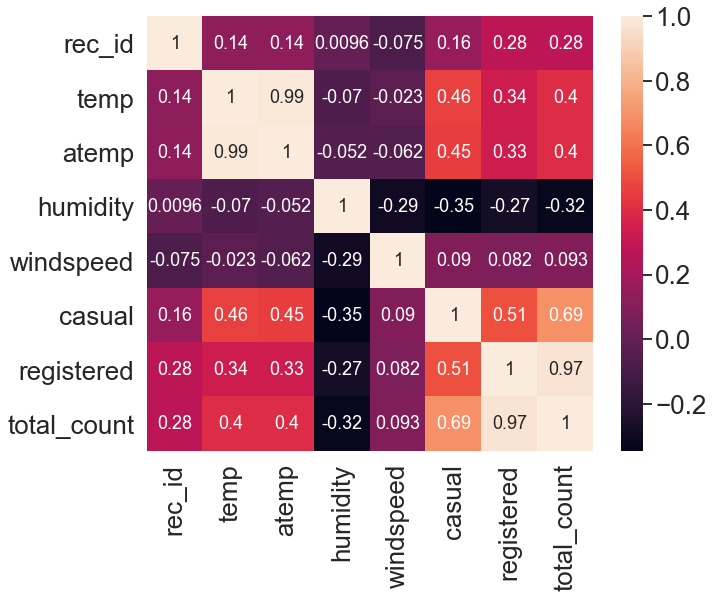

In [16]:
# Correlation Matrix
plt.figure(figsize=(10,8))
c= hour_df.corr()
sns.heatmap(c,annot=True)

In [17]:
# Removed atemp as it is highly correlated with temp variable and register variable is highly correlated with total count.
hour_df=hour_df.drop(['atemp','registered'], axis = 1)

In [18]:
hist_Columns = list(i for i in hour_df.select_dtypes([np.number]))#.columns if i in ['total_count','casual',
                       # 'temp','humidity'])

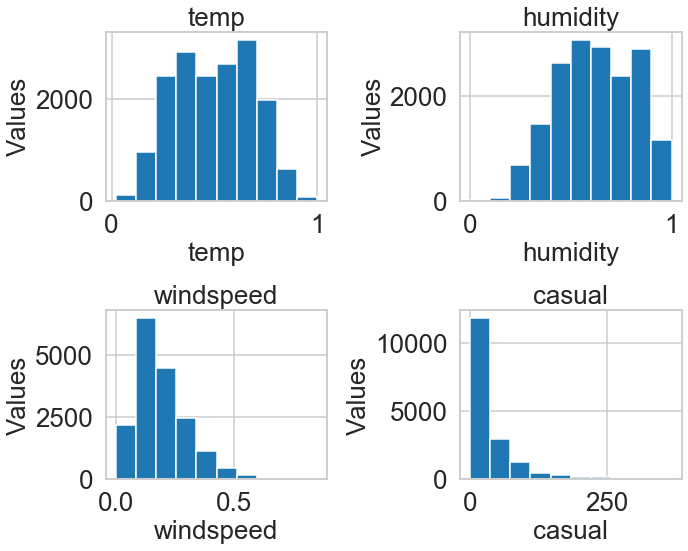

In [19]:
#Unbalanced Distribution
count=1
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10,8)) 
#plt.figure(figsize=(20,10))
for i in range(2):
    for j in range(2):
        if(hist_Columns[count]=='total_count'):
            axs[i,j].hist(hour_df[hist_Columns[count]])
            axs[i,j].set(title = hist_Columns[count]+'(Targetvalue)', xlabel= hist_Columns[count],ylabel='Values')
            count+=1
        else:
            axs[i,j].hist(hour_df[hist_Columns[count]])
            axs[i,j].set(title = hist_Columns[count], xlabel= hist_Columns[count],ylabel='Values')
            count+=1

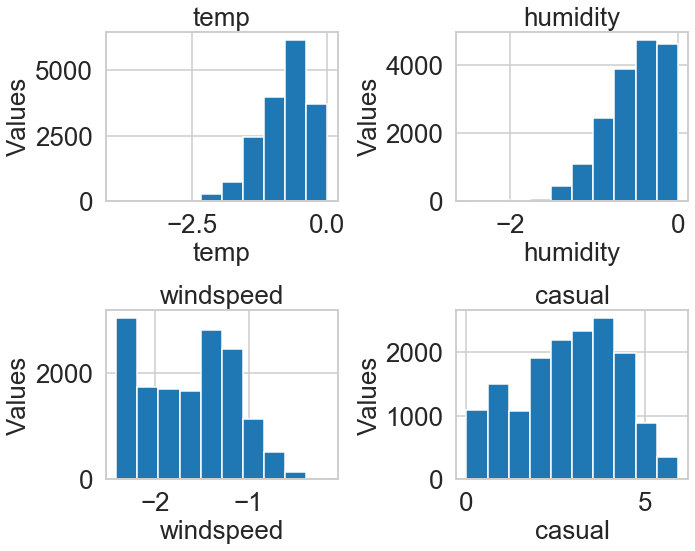

In [20]:
#Balanced Distribution
count=1
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10,8)) 
#plt.figure(figsize=(20,10))
for i in range(2):
    for j in range(2):
        if((hist_Columns[count]=='price') or (hist_Columns[count]=='minimum_nights')):
            axs[i,j].hist(np.log(hour_df[hist_Columns[count]]+0.5))
            axs[i,j].set(title = hist_Columns[count]+'(Targetvalue)', xlabel= hist_Columns[count],ylabel='Values')
            count+=1
        else:
            axs[i,j].hist(np.log(hour_df[hour_df[hist_Columns[count]]!=0][hist_Columns[count]]))
            axs[i,j].set(title = hist_Columns[count], xlabel= hist_Columns[count],ylabel='Values')
            count+=1

In [21]:
int_df = hour_df.select_dtypes(include=['int64']).copy()
float_df = hour_df.select_dtypes(include=['float64']).copy()
num_df = pd.concat([float_df, int_df], axis = 1)
num_df= num_df.drop('rec_id', axis = 1)
num_df.head()

,temp,humidity,windspeed,casual,total_count
0,0.24,0.81,0.0,3,16
1,0.22,0.80,0.0,8,40
2,0.22,0.80,0.0,5,32
3,0.24,0.75,0.0,3,13
4,0.24,0.75,0.0,0,1


#### Checking the skeweness of the continous variable

In [29]:
#num_feats = num_df.dtypes[num_df.dtypes =='numeric'].index
skew_feats = num_df.skew().sort_values(ascending= False)
skewness= pd.DataFrame({'Skew':skew_feats})
skewness

,Skew
casual,2.499237
total_count,1.277412
windspeed,0.574905
temp,-0.006021
humidity,-0.111287


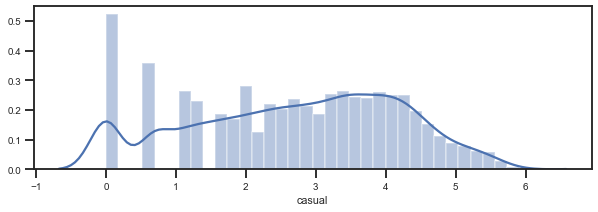

In [30]:
#log transformation
log_casual = np.log(hour_df.casual+1)
sns.distplot(log_casual)


In [31]:
hour_df['log_casual'] = log_casual
hour_df.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,casual,total_count,log_casual
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1.386294
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,2.197225
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1.791759
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1.386294
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,0.000000


## Target Variable : total_count

In [32]:
hour_df['total_count'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: total_count, dtype: float64

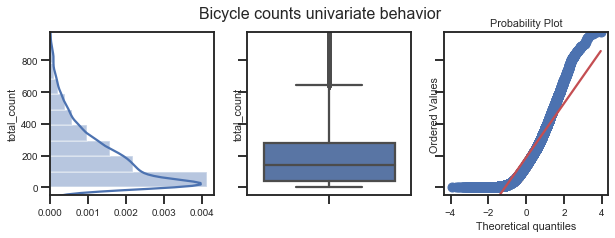

In [33]:
scaler = preprocessing.StandardScaler()
sns.set( context='talk', style='ticks', font_scale=0.6, rc={'figure.figsize':(10,3)}) 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.suptitle('Bicycle counts univariate behavior', fontsize=16, y=1)

g = sns.distplot(hour_df.total_count, bins=10, vertical=True, ax=axes[0])
g.set_ylim(ymin=hour_df.total_count.min()-50, ymax=hour_df.total_count.max())
g = sns.boxplot(y=hour_df.total_count, data=hour_df, ax=axes[1])
g = stats.probplot(hour_df.total_count, dist='norm', fit=True, plot=axes[2])
plt.show()
plt.close('all')

In [35]:
hour_df['log_total_count'] = np.log(hour_df.total_count)
hour_df.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,casual,total_count,log_casual,log_total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1.386294,2.772589
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,2.197225,3.688879
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1.791759,3.465736
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1.386294,2.564949
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,0.000000,0.000000


### Outlier Removed by log transformation

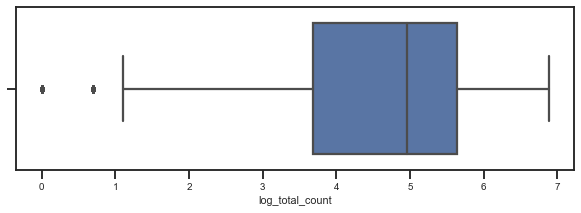

In [36]:
sns.boxplot(x=hour_df.log_total_count, data=hour_df)

## Effect of Numerical features on Response variable

Text(0, 0.5, 'Count of all Biks Rented')

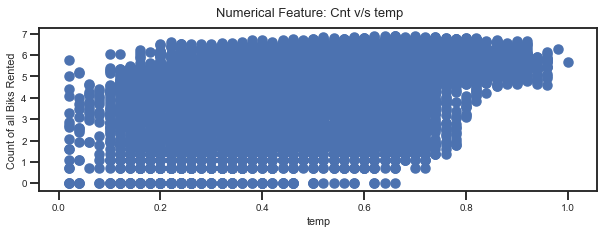

In [37]:
#Temp vs Count(as the temp gets warmer more bikes get rented.)
plt.scatter(hour_df['temp'], hour_df['log_total_count'])
plt.suptitle('Numerical Feature: Cnt v/s temp')
plt.xlabel('temp')
plt.ylabel('Count of all Biks Rented')

Text(0, 0.5, 'Count of all Biks Rented')

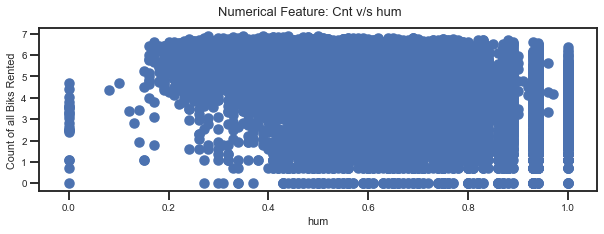

In [38]:
plt.scatter(hour_df['humidity'], hour_df['log_total_count'])
plt.suptitle('Numerical Feature: Cnt v/s hum')
plt.xlabel('hum')
plt.ylabel('Count of all Biks Rented')

Text(0, 0.5, 'Count of all Biks Rented')

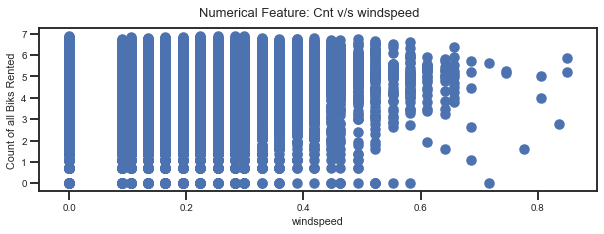

In [39]:
plt.scatter(hour_df['windspeed'], hour_df['log_total_count'])
plt.suptitle('Numerical Feature: Cnt v/s windspeed')
plt.xlabel('windspeed')
plt.ylabel('Count of all Biks Rented')

## Check for categorical features on response variable

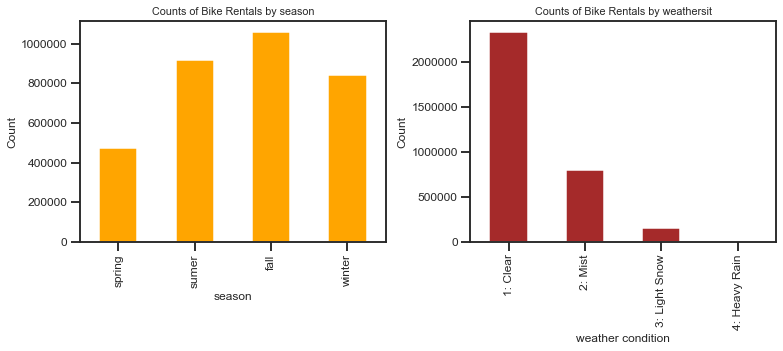

In [40]:

f,(ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
ax1 = hour_df[['season','total_count']].groupby(['season']).sum().reset_index().plot(kind='bar',
                                       legend = False, title ="Counts of Bike Rentals by season", 
                                         color='orange',stacked=True, fontsize=12, ax=ax1)
ax1.set_xlabel("season", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_xticklabels(['spring','sumer','fall','winter'])

 
ax2 = hour_df[['weather_condition','total_count']].groupby(['weather_condition']).sum().reset_index().plot(kind='bar',  
      legend = False, stacked=True,color='brown', title ="Counts of Bike Rentals by weathersit", fontsize=12, ax=ax2)

ax2.set_xlabel("weather condition", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_xticklabels(['1: Clear','2: Mist','3: Light Snow','4: Heavy Rain'])

f.tight_layout()

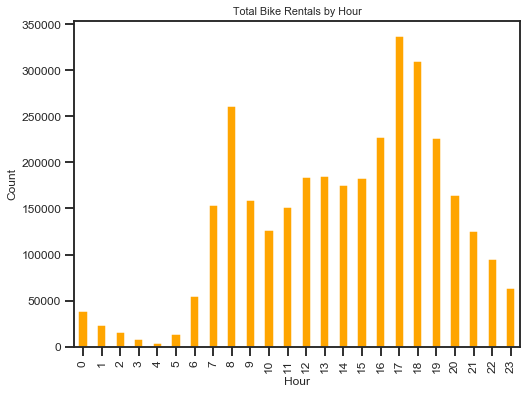

In [43]:
#alternative way of plotting using groupby
ax = hour_df[['hour','total_count']].groupby(['hour']).sum().reset_index().plot(kind='bar', figsize=(8, 6),
                                       legend = False, title ="Total Bike Rentals by Hour", 
                                       color='orange', fontsize=12)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

## Modeling the Dataset

In [44]:
hour_df.head()

,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,casual,total_count,log_casual,log_total_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1.386294,2.772589
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,2.197225,3.688879
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1.791759,3.465736
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1.386294,2.564949
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,0.000000,0.000000


In [45]:
bike_df_model = hour_df.copy()
Y = bike_df_model.iloc[:,[16]]
Y.head()

,log_total_count
0,2.772589
1,3.688879
2,3.465736
3,2.564949
4,0.000000


In [46]:
X = bike_df_model.iloc[:,[2,5,6,7,8,9,10,11,12,15]]
X.head()

,season,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,log_casual
0,1,0,0,6,0,1,0.24,0.81,0.0,1.386294
1,1,1,0,6,0,1,0.22,0.80,0.0,2.197225
2,1,2,0,6,0,1,0.22,0.80,0.0,1.791759
3,1,3,0,6,0,1,0.24,0.75,0.0,1.386294
4,1,4,0,6,0,1,0.24,0.75,0.0,0.000000


In [47]:
#spliting data into train and test portion
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=0)

In [48]:
display(X_train[X_train['windspeed']==0].head(),X_test.head())

,season,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,log_casual
3943,2,5,0,6,0,1,0.62,0.83,0.0,0.693147
6608,4,22,0,5,1,1,0.50,0.68,0.0,3.332205
10416,1,3,0,4,1,1,0.50,0.63,0.0,0.000000
6631,4,21,0,6,0,1,0.52,0.77,0.0,4.007333
14307,3,8,0,5,1,2,0.66,0.74,0.0,3.737670


,season,hour,is_holiday,weekday,is_workingday,weather_condition,temp,humidity,windspeed,log_casual
3439,2,5,0,6,0,1,0.56,0.88,0.2239,1.609438
6542,4,4,0,3,1,1,0.44,0.88,0.0000,0.693147
15470,4,19,0,4,1,1,0.44,0.51,0.1343,4.406719
9851,1,11,1,1,0,1,0.26,0.48,0.3582,3.828641
12640,2,21,0,5,1,1,0.66,0.50,0.1045,4.430817


In [49]:
y_train.shape

(13903, 1)

## Multiple Linear Regression

In [50]:
from sklearn import linear_model
lr_model = linear_model.LinearRegression()

In [51]:
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
coeff_df = pd.DataFrame(lr_model.coef_.reshape(-1,1), X.columns, columns=['Coefficient'])  
coeff_df.sort_values('Coefficient',inplace=True,ascending=False)
coeff_df.style.background_gradient(cmap=sns.light_palette("Yellow", as_cmap=True))

,Coefficient
log_casual,0.876859
is_workingday,0.547527
humidity,0.194436
windspeed,0.177726
season,0.063490
hour,0.034836
weekday,0.008285
weather_condition,0.006664
is_holiday,0.005759
temp,-1.146451


In [53]:
y_pred = lr_model.predict(X_test)
y_pred

array([[2.94566307],
       [2.85480296],
       [6.59383348],
       ...,
       [4.12473479],
       [1.8001389 ],
       [5.33051034]])

In [54]:
my_dict = {'Actual': y_test.values.reshape(-1), 'Predicted': y_pred.reshape(-1)}
df = pd.DataFrame(my_dict)
cm = sns.light_palette("pink", as_cmap=True)
df.head().style.background_gradient(cmap=cm)


,Actual,Predicted
0,1.945910,2.945663
1,1.609438,2.854803
2,6.610696,6.593833
3,5.337538,5.291482
4,5.808142,6.306481


In [55]:
MAE_lm = round(metrics.mean_absolute_error(y_test, y_pred)*100,2)
RMSE_lm = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))*10,2)
Accuracy_lm = round(lr_model.score(X_test,y_test)*100,2)
print('Mean Absolute Error:', MAE_lm)
print('Root Mean Squared Error:', RMSE_lm)
print('Accuracy : ', Accuracy_lm)
# cross validation
CV_lm = round(np.mean(cross_val_score(lr_model, X_train, y_train, cv=10))*100,2)
print('Crossvalidation acc:',CV_lm)

Mean Absolute Error: 52.87
Root Mean Squared Error: 7.1
Accuracy :  77.47
Crossvalidation acc: 77.95


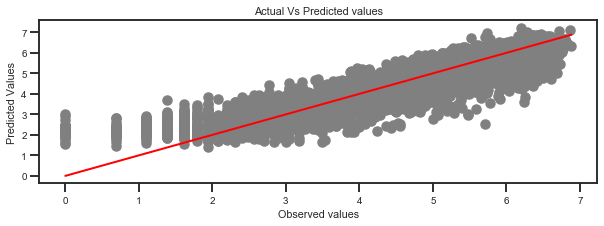

In [56]:
plt.scatter(y_test,y_pred,  color='gray')
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()] ,color='red', linewidth=2)
plt.title('Actual Vs Predicted values')
plt.xlabel('Observed values')
plt.ylabel('Predicted Values')
plt.show()

## Decision Tree Regressor

In [57]:

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

C:\Users\badol\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [58]:
dtr = DecisionTreeRegressor(random_state=1,max_depth=3)
dtr.fit(X_train,y_train)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
#export_graphviz(dtr, out_file=dot_data,  
 #               filled=True, rounded=True,
 #               special_characters=True)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

In [59]:
dtr = DecisionTreeRegressor(random_state=1,max_depth=10)
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)

In [60]:
MAE_dtr = round(metrics.mean_absolute_error(y_test, y_pred)*100,2)
RMSE_dtr = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))*10,2)
Accuracy_dtr = round(dtr.score(X_test,y_test)*100,2)
print('Mean Absolute Error:', MAE_dtr)
print('Root Mean Squared Error:', RMSE_dtr)
print('Accuracy : ', Accuracy_dtr)
# cross validation
CV_dtr = round(np.mean(cross_val_score(dtr, X_test, y_test, cv=10))*100,2)
print('Crossvalidation acc:',CV_dtr)

Mean Absolute Error: 30.46
Root Mean Squared Error: 4.3
Accuracy :  91.72
Crossvalidation acc: 88.92


In [61]:
max_depth_arr = [3,4,5,6,7,8,10,12,14,16,20,22,25,27,28,30,35,40]
MAE_arr = []
for i in max_depth_arr:
    dtr = DecisionTreeRegressor(random_state=1,max_depth=i)
    dtr.fit(X_train,y_train)
    y_pred = dtr.predict(X_test)
    MAE_arr.append(round(metrics.mean_absolute_error(y_test, y_pred)*100,2))

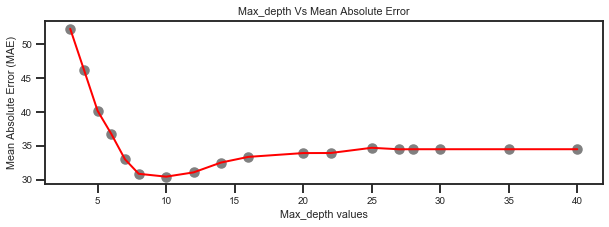

In [62]:
plt.scatter(max_depth_arr,MAE_arr,  color='gray')
plt.plot(max_depth_arr,MAE_arr,color='red', linewidth=2)
plt.title('Max_depth Vs Mean Absolute Error')
plt.xlabel('Max_depth values')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()

## Final Results

In [63]:
final_res_df = pd.DataFrame({'ML Models' : ['Multiple Linear Regression','Decision Tree Regressor'],
              'Accuracy in %' : [Accuracy_lm,Accuracy_dtr],
             'MAE':[MAE_lm,MAE_dtr],
             'RMSE':[RMSE_lm,RMSE_dtr],
             'CV Score in %':[CV_lm,CV_dtr]})


In [64]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = final_res_df.style.background_gradient(cmap=cm)
s

,ML Models,Accuracy in %,MAE,RMSE,CV Score in %
0,Multiple Linear Regression,77.470000,52.870000,7.100000,77.950000
1,Decision Tree Regressor,91.720000,30.460000,4.300000,88.920000
